# **Example application of the Self-Organising Map algorithm**
This notebook illustrates the usage of the `Self_Organising_Map` class and its methods. Self-Organising Maps (SOMs) are an unsupervised machine learning algorithm used to reduce the dimensionality of high-dimensional datasets to a typically two-dimensional neural map. During this process, the topological structure of the data is preserved, i.e. neural classes of similar data are near each other, while dissimilar classes are separated in the two-dimensional space (Kohonen, 1982). This implementation of a SOM algorithm utilises a batch algorithm, for which the whole training dataset is gone through at once and only after this is the SOM updated with the net effect of all samples. The SOM is updated by replacing the map with a weighted average over the samples, where the weighting factors are the neighbourhood function values.

The `Self_Organising_Map` class offers different options for the type of the lattice, which can either be rectangular with 8 direct neighbours, or hexagonal with 6 direct neighbours. Furthermore, the lattice can be planar or toroidal. The `Self_Organising_Map` class also offers the option to use chunking and a dask cluster to perform calculations on large datasets.

The workflow of how to use the `Self_Organising_Map` class is illustrated in the following on an example dataset. Generally, the workflow follows three basic steps:
1. The `Self_Organising_Map` object is initialised
2. The `Self_Organising_Map` object is compiled, i.e. the type and (approximate) size of the lattice is set
3. The SOM is trained on a training dataset

Afterwards several methods are available to evaluate the trained SOM and visualise the topological map. More details are included in the doc strings are available for each of the methods.

> Kohonen, T. (1982). Self-organized formation of topologically correct feature maps. *Biological Cybernetics, 43*. doi:[10.1007/BF00337288](https://www.doi.org/10.1007/BF00337288)

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from sklearn.model_selection import train_test_split
from itcompsom_routines import (
    # Scaler,
    Self_Organising_Map,
    plot_map_structure
)
import matplotlib.pyplot as plt

## The example dataset
To illustrate the usage of the `Self_Organising_Map` class, the chain link dataset is used, which was shown to be a good "benchmark" for testing algorithms for clustering purposes (Ultsch, 1995). The chain link dataset is split into a training and testing datasets in order to assess the performance of the employed algorithm on unseen data.

> Ultsch, A. (1995). Self organizing neural networks perform different from statistical k-means clsutering. *Gesellschaft f. Klassifikation*. (Basel, 8th-10th March)

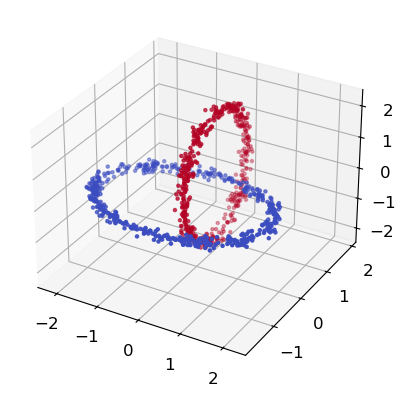

In [2]:
# The chain link dataset is loaded into memory and the features (i.e. x, y,
# and z) are normalised to have zero mean and unit standard deviation.
chainlink_data = pd.read_csv(
    "chainlink_dataset.csv",
    header = None,
    names = ["x", "y", "z", "cluster"]
)
chainlink_data.iloc[:, :3] = chainlink_data.iloc[:, :3].apply(
    lambda col : (col - col.mean()) / col.std(),
    axis = "index"
)
chainlink_data.index.names = ["sample"]
# The dataset is split into training and testing datasets with an 80:20 ratio.
training_data, testing_data = train_test_split(
    chainlink_data,
    test_size = 0.2,
    random_state = 12345
)
# The training and testing datasets are converted into the format expected by
# the Self_Organising_Map class, i.e. an xarray.DataArray with the dimensions
# 'sample' and 'feature'.
chainlink_data = chainlink_data.to_xarray()
chainlink_data = xr.merge([
    chainlink_data[["x", "y", "z"]].to_array("feature", name = "xyz"),
    chainlink_data[["cluster"]]
])
training_data = training_data.to_xarray().assign_coords({
    "sample" : range(len(training_data))
})
training_data = xr.merge([
    training_data[["x", "y", "z"]].to_array("feature", name = "xyz"),
    training_data[["cluster"]]
])
testing_data = testing_data.to_xarray().assign_coords({
    "sample" : range(training_data.sample.size, chainlink_data.sample.size)
})
testing_data = xr.merge([
    testing_data[["x", "y", "z"]].to_array("feature", name = "xyz"),
    testing_data[["cluster"]]
])
# The chain link dataset represents two intertwined three-dimensional rings,
# where each ring forms one cluster (red and blue in the figure below).
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(
    chainlink_data.xyz.sel(feature = "x"),
    chainlink_data.xyz.sel(feature = "y"),
    chainlink_data.xyz.sel(feature = "z"),
    s = 5,
    c = chainlink_data.cluster,
    cmap = "coolwarm"
)
ax.tick_params(
    direction = "in",
    labelsize = 12
)

## Training a Self-Organising Map
The training dataset is used to train the SOM, which is compiled to have a size of $64 \times 64$ cells on a hexagonal, toroidal grid. Starting from an initial neighbourhood radius of $20$, the SOM is trained for $30$ epochs until the final neighbourhood radius of $1$ is reached.

In [3]:
# First, the Self_Organising_Map object is initialised. Since the dataset is
# quite small, no dask cluster and chunking of the dataset is necessary.
chainlink_som = Self_Organising_Map(
    f_chunk_size = "auto",
    f_dask_cluster = None,
    f_random_state = 12345,
    f_verbose = 1
)
# Next, the SOM is compiled, where the size of the topological map is set to
# 64x64, as in the example in Ultsch, 1995. A hexagonal, toroidal map is
# chosen for this illustration.
chainlink_som.compile(
    f_features = training_data.feature.values,
    f_SOM_cols = 64,
    f_SOM_rows = 64,
    f_SOM_size = None,
    f_lattice = "hexa",
    f_shape = "toroid"
)
# The SOM is trained on the training dataset for 30 epochs and an initial
# neighbourhood radius of 20 and a final neighbourhood radius of 1.
som_results = chainlink_som.train(
    f_data_features = training_data.xyz,
    f_data_labels = training_data.cluster,
    f_epochs = 30,
    f_neighbourhood_radius = {"s1" : 20., "s0" : 1., "b" : None}
)

Update SOM classes: 100%|████████████████████████████| 30/30 [00:31<00:00,  1.04s/it]


## Visualising the topological map and the results
The trained SOM can be visualised in different ways. An easy and quick way is by using the `visualise_SOM` method of the `Self_Organising_Map` object. It automatically generates a figure and subplots for the features to be displayed on the grid, which is displayed as a planar grid, even if a toroidal grid was chosen. A colourmap can be assigned to the respective features, or multiple features can be grouped together. In the latter case, the first feature is assigned the colour red, the second feature is assigned green, and the third feature is assigned blue. Displayed are the weights of each feature at each grid cell of the SOM, where the relative importance is displayed through the mixing of the colours.

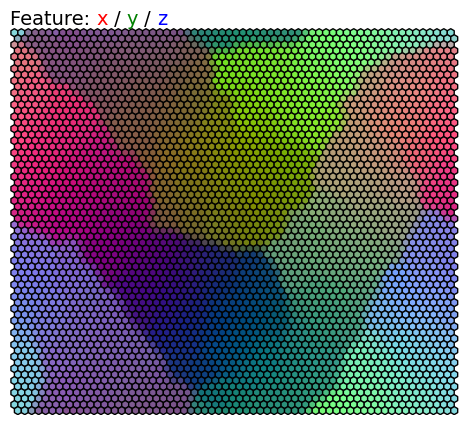

In [4]:
fig, ax = chainlink_som.visualise_SOM(
    f_figure_width = 5,
    f_feature_dict = {("x", "y", "z") : None}
)

A more complex plotting routine is available through the `plot_map_structure` function. This function can be used to plot the topological map into an existing axis, where the colourbar can be adjusted as well. Furthermore, toroidal maps can be displayed in a three-dimensional projection.

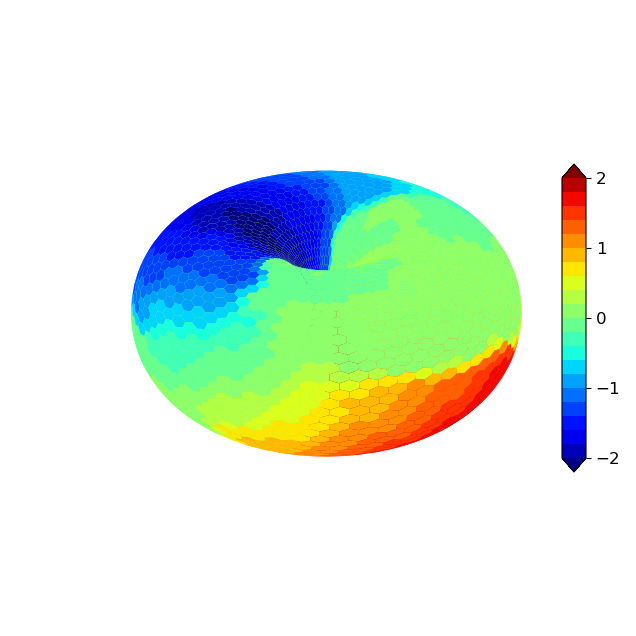

In [5]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = "3d")
dct = plot_map_structure(
    f_figure = fig,
    f_axis = ax,
    f_colourbar_params = {
        "vmin" : -2.,
        "vmax" : 2.,
        "levels" : 21,
        "cmap" : "jet",
        "orientation" : "vertical"
    },
    f_data = som_results.weights.sel(
        feature = "z"
    ).values.reshape(
        (som_results.m, som_results.n)
    ),
    f_lattice = ("hexa", "toroid"),
    f_projection = "3d",
    f_show_grid_cell_boundaries = False
)

An alternative to visualising the weights of each feature at the grid cells of the SOM is the usage of the so-called *U-matrix*, *P-matrix*, or *U\*-matrix* (Ultsch & Mörchen, 2005). The U-matrix gives the local distance structure at each grid cell, which is calculated as teh sum of the distances between a SOM class and all of its immediate neighbours. The P-matrix gives the local data density at each grid cell and is calculated as the number of data points within a defined hypersphere around each grid cell. The U\*-matrix is a scaled version of the U-matrix, whose values are dampened in highly dense regions, unaltered in regions of average denisty, and emphasised in sparse regions. This allows for a more clear depiction of cluster boundaries, which are associated with high values in the U\*-matrix.

In the following cell, the U\*-matrix is computed using the `compute_ustarmatrix` method of the `Self_Organising_Map` object and displayed using the `plot_map_structure` function. By plotting the best-matching units and associated labels of the original chain link dataset on top of the U\*-matrix showcases the separation of the two rings into clusters by the SOM algorithm.

> Ultsch, A. & Mörchen F. (2005). ESOM-Maps: Tools for clustering, visualization, and classification with Emergent SOM.

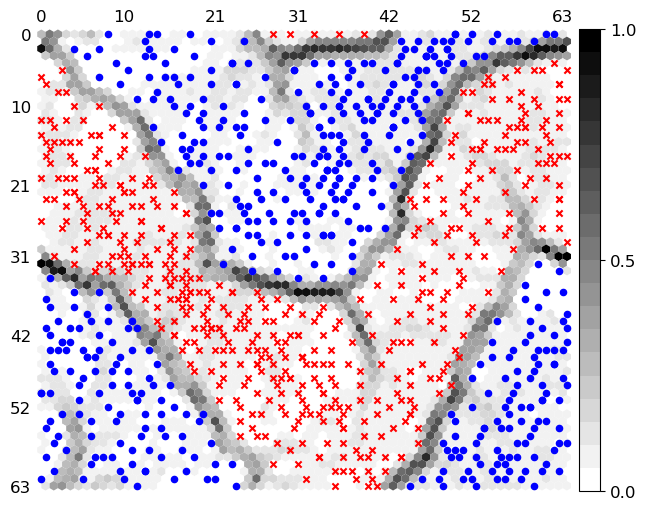

In [6]:
# Compute the U*-matrix.
chainlink_ustar = chainlink_som.compute_ustarmatrix()
# Determine the best-matching units of the individual data points in the chain
# link dataset.
chainlink_data = chainlink_data.assign({
    "bmus" : chainlink_som._find_bmu(
        f_data = chainlink_data.xyz.transpose("sample", "feature"),
        f_mask = None,
        f_num_values = 1
    )
})
# Determine the coordinates of the best-matching units on the hexagonal grid
# for plotting purposes.
Xgrid, Ygrid = np.meshgrid(
    np.arange(chainlink_som.n, dtype = "float32"),
    np.arange(chainlink_som.m, dtype = "float32")
)
Xgrid[1::2, :] += 0.5
Ygrid *= np.sqrt(3.) / 2.
lookup_table = {
    idx : (iy + 1j * ix)
    for idx, ix, iy in zip(
        chainlink_som._indices,
        Xgrid.ravel(),
        Ygrid.ravel()
    )
}
bmu_coords = np.array([
    lookup_table[n] for n in chainlink_data.bmus.values
])
# Plot the U*-matrix on its hexagonal grid.
fig, ax = plt.subplots(
    figsize = (7, 6),
    ncols = 1
)
_ = plot_map_structure(
    f_figure = fig,
    f_axis = ax,
    f_colourbar_params = {
        "levels" : np.linspace(0., 1., 21),
        "cmap" : "gray_r"
    },
    f_data = chainlink_ustar.values.reshape(
        (chainlink_som.m, chainlink_som.n)
    ),
    f_lattice = (chainlink_som.lattice, chainlink_som.shape),
    f_projection = "2d",
    f_show_grid_cell_boundaries = False
)
# Plot the best-matching units of the chain link dataset, where red and blue
# represent one cluster each.
ax.scatter(
    bmu_coords.imag[chainlink_data.cluster == 1],
    bmu_coords.real[chainlink_data.cluster == 1],
    s = 20,
    c = "red",
    marker = "x"
)
ax.scatter(
    bmu_coords.imag[chainlink_data.cluster == 2],
    bmu_coords.real[chainlink_data.cluster == 2],
    s = 20,
    c = "blue",
    marker = "o"
);

As is visible from the figure above, the topolical map shows clear boundaries (dark shading) that separate the data points associated with each ring of the chain link dataset well into two clusters.
## Evaluating the performance
To evaluate the prediction skill of the trained SOM, the testing dataset is used. Based on the best-matching unit of a data point, the cluster to which it belongs can be predicted. The `Self_Organising_Map` object has a `predict` method, which can be used for this purpose. Furthermore, an `evaluate` method is available that first makes a prediction for the supplied data and then compares the predictions to the true values. The `evaluate` method then returns either the root mean square error, the mean absolute error, the median absolute deviation, or the accuracy, which is the fraction of correctly predicted data points.

In [7]:
chainlink_som.evaluate(
    f_data_features = testing_data.xyz,
    f_data_labels = testing_data.cluster,
    f_mask = None,
    f_metric = "accuracy"
)

1.0